In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, explained_variance_score

In [2]:
outliers_df = pd.read_csv('outliers-data.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7757 entries, 0 to 7756
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             7757 non-null   float64
 1   bath            7757 non-null   float64
 2   acre_lot        7757 non-null   float64
 3   zip_code        7757 non-null   float64
 4   house_size      7757 non-null   float64
 5   prev_sold_date  7757 non-null   object 
 6   price           7757 non-null   float64
dtypes: float64(6), object(1)
memory usage: 424.3+ KB


In [4]:
outliers_df["prev_sold_year"] = pd.to_datetime(outliers_df["prev_sold_date"], format='%Y-%m-%d').dt.year
outliers_df.drop(columns=["prev_sold_date"],inplace=True)
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7757 entries, 0 to 7756
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             7757 non-null   float64
 1   bath            7757 non-null   float64
 2   acre_lot        7757 non-null   float64
 3   zip_code        7757 non-null   float64
 4   house_size      7757 non-null   float64
 5   price           7757 non-null   float64
 6   prev_sold_year  7757 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 424.3 KB


In [5]:
zip_lon_lat = pd.read_csv("county.csv")
zip_lon_lat.head()

,Unnamed: 0,zip_code,latitude,longitude,zip_code_str,county
0,0,7001,40.582316,-74.271506,7001,16
1,1,7002,40.662338,-74.110275,7002,2
2,2,7003,40.809128,-74.187155,7003,2
3,3,7004,40.882508,-74.304593,7004,19
4,4,7005,40.932771,-74.417304,7005,19


In [6]:
merged_df = pd.merge(outliers_df, zip_lon_lat, how="inner", on="zip_code")
merged_df.tail()

,bed,bath,acre_lot,zip_code,house_size,price,prev_sold_year,Unnamed: 0,latitude,longitude,zip_code_str,county
7749,5.0,4.0,0.91,8848.0,0.0,485000.0,2017,568,40.594266,-75.096659,8848,11
7750,4.0,3.0,2.17,8825.0,0.0,510000.0,2016,553,40.514169,-75.027112,8825,11
7751,3.0,2.0,0.12,7012.0,0.0,499000.0,2021,10,40.848398,-74.160266,7012,2
7752,3.0,3.0,0.13,7012.0,0.0,530000.0,2022,10,40.848398,-74.160266,7012,2
7753,4.0,3.0,0.11,7640.0,0.0,720000.0,2016,171,40.991681,-73.980202,7640,15


In [7]:
features = ["latitude","longitude","bed","bath","acre_lot","house_size","prev_sold_year"]
num_features_to_select = len(features)-1
random_state_value = 42

In [8]:
X = merged_df[features]
y = merged_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

In [9]:
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[], "mean fit time":[]}

In [10]:
def print_more_stuff(title, y_param, predict_param, gscv):
    results_dict["model"].append(title)
    
    evs = "{:.9f}".format(explained_variance_score(y_param,predict_param))
    mae = "{:,.6f}".format(mean_absolute_error(y_param,predict_param))
    mse = "{:,.6f}".format(mean_squared_error(y_param,predict_param))
    r2 = "{:,.6f}".format(r2_score(y_param,predict_param))
    
    #find_best_params = gscv.cv_results_["params"].index(gscv.best_params_)
    #mean_fit_time = gscv.cv_results_["mean_fit_time"][find_best_params]
    mean_fit_time = gscv.cv_results_["mean_fit_time"][gscv.best_index_]
    
    results_dict["explained variance score"].append(evs)
    results_dict["mae score"].append(mae)
    results_dict["mse score"].append(mse)
    results_dict["r2 score"].append(r2)
    results_dict["mean fit time"].append(mean_fit_time)
    
    print(title + " EVS = " + evs)
    print(title + " MSE = " + mse)
    print(title + " MAE = " + mae)
    print(title + " R2 = " + r2)
    print(title + " Fit Time = " + str(mean_fit_time))

In [11]:
lasso = Lasso(random_state=42)
lasso_sfs = SequentialFeatureSelector(estimator=lasso, n_features_to_select=num_features_to_select)
lasso_sfm = SelectFromModel(estimator=lasso, threshold=1000)
lasso_rfe = RFE(estimator=lasso, n_features_to_select=num_features_to_select)


poly_features = PolynomialFeatures(degree=3,include_bias=False)
lasso_step = Lasso(random_state=42)

auto_pipe = Pipeline([("polyfeatures",poly_features),("scaler",StandardScaler()),("lasso",lasso_step)])
auto_pipe.fit(auto_X_train, auto_y_train)

lasso_coefs = auto_pipe.named_steps['lasso'].coef_


In [12]:
myrange = []
for i in range(12,17):
    myrange.append(10**-i)
param_dict = {'alpha': myrange}
lasso_gscv = GridSearchCV(Lasso(), param_grid=param_dict, scoring='neg_mean_squared_error')
lasso_gscv_model = lasso_gscv.fit(X, y)
print(f"Best parameters found: {lasso_gscv.best_params_}")

Best parameters found: {'alpha': 1e-14}


##### Alpha appears to be insignificant, so the default value = 1 is our best option

In [13]:
lasso = Lasso(**lasso_gscv.best_params_)
lasso_bp_gscv = GridSearchCV(lasso, param_grid={})
lasso_bp_model = lasso_bp_gscv.fit(X_train,y_train)
lasso_bp_predict = lasso_bp_model.predict(X_test)

print_more_stuff("Lasso Best Params", y_test, lasso_bp_predict, lasso_bp_gscv)

Lasso Best Params EVS = 0.413528582
Lasso Best Params MSE = 103,916,325,992.270248
Lasso Best Params MAE = 214,079.047688
Lasso Best Params R2 = 0.413192
Lasso Best Params Fit Time = 0.5704637050628663


In [14]:
lasso_sfm_pipeline = Pipeline([
  ('feature_selection', lasso_sfm),
  ('regression', lasso)
])

lasso_sfm_fs = lasso_sfm_pipeline.named_steps['feature_selection'].fit(X,y)
lasso_sfm_selected_features = lasso_sfm_fs.get_support()

print('The selected features are:', list(X.columns[lasso_sfm_selected_features]))

The selected features are: ['latitude', 'longitude', 'bed', 'bath', 'acre_lot', 'prev_sold_year']


In [15]:
X_sfm = merged_df[list(X.columns[lasso_sfm_selected_features])]
y_sfm = merged_df["price"]
X_sfm_train, X_sfm_test, y_sfm_train, y_sfm_test = train_test_split(X_sfm, y_sfm, test_size=0.3, random_state=random_state_value)

In [16]:
lasso_sfm_gscv = GridSearchCV(Lasso(), param_grid={})
lasso_sfm_model = lasso_sfm_gscv.fit(X_sfm_train,y_sfm_train)
lasso_sfm_predict = lasso_sfm_model.predict(X_sfm_test)

print_more_stuff("Select From Model",y_sfm_test,lasso_sfm_predict,lasso_sfm_gscv)

Select From Model EVS = 0.412534909
Select From Model MSE = 104,103,878,550.355606
Select From Model MAE = 214,333.413424
Select From Model R2 = 0.412133
Select From Model Fit Time = 0.010481882095336913


In [17]:
lasso_sfs_pipeline = Pipeline([
  ('feature_selection', lasso_sfs),
  ('regression', lasso)
])

lasso_sfs_fs = lasso_sfs_pipeline.named_steps['feature_selection'].fit(X,y)
lasso_sfs_selected_features = lasso_sfs_fs.get_support()

print('The selected features are:', list(X.columns[lasso_sfs_selected_features]))

The selected features are: ['latitude', 'longitude', 'bed', 'bath', 'house_size', 'prev_sold_year']


In [18]:
X_sfs = merged_df[list(X.columns[lasso_sfs_selected_features])]
y_sfs = merged_df["price"]
X_sfs_train, X_sfs_test, y_sfs_train, y_sfs_test = train_test_split(X_sfs, y_sfs, test_size=0.3, random_state=random_state_value)

In [19]:
lasso_sfs_gscv = GridSearchCV(Lasso(), param_grid={})
lasso_sfs_model = lasso_sfs_gscv.fit(X_sfs_train,y_sfs_train)
lasso_sfs_predict = lasso_sfs_model.predict(X_sfs_test)

print_more_stuff("Sequential Feature Selector",y_sfs_test,lasso_sfs_predict, lasso_sfs_gscv)

Sequential Feature Selector EVS = 0.411503194
Sequential Feature Selector MSE = 104,278,409,374.292221
Sequential Feature Selector MAE = 214,408.235731
Sequential Feature Selector R2 = 0.411148
Sequential Feature Selector Fit Time = 0.014208030700683594


In [20]:
lasso_rfe_pipeline = Pipeline([
  ('feature_selection', lasso_rfe),
  ('regression', lasso)
])
lasso_rfe_fs = lasso_rfe_pipeline.named_steps['feature_selection'].fit(X,y)
lasso_rfe_selected_features = lasso_rfe_fs.get_support()

print('The selected features are:', list(X.columns[lasso_rfe_selected_features]))

The selected features are: ['latitude', 'longitude', 'bed', 'bath', 'acre_lot', 'prev_sold_year']


In [21]:
X_rfe = merged_df[list(X.columns[lasso_rfe_selected_features])]
y_rfe = merged_df["price"]
X_rfe_train, X_rfe_test, y_rfe_train, y_rfe_test = train_test_split(X_rfe, y_rfe, test_size=0.3, random_state=random_state_value)

In [22]:
lasso_rfe_gscv = GridSearchCV(Lasso(), param_grid={})
lasso_rfe_model = lasso_rfe_gscv.fit(X_rfe_train,y_rfe_train)
lasso_rfe_predict = lasso_rfe_model.predict(X_rfe_test)

print_more_stuff("Recursive Feature Elimination",y_rfe_test,lasso_rfe_predict, lasso_rfe_gscv)

Recursive Feature Elimination EVS = 0.412534909
Recursive Feature Elimination MSE = 104,103,878,550.355606
Recursive Feature Elimination MAE = 214,333.413424
Recursive Feature Elimination R2 = 0.412133
Recursive Feature Elimination Fit Time = 0.007661581039428711


In [23]:
lasso_bp_predict_df = pd.DataFrame(lasso_bp_predict).reset_index()
lasso_bp_predict_df.rename(columns={0: "prediction"},inplace=True)

lasso_sfm_predict_df = pd.DataFrame(lasso_sfm_predict).reset_index()
lasso_sfm_predict_df.rename(columns={0: "prediction"},inplace=True)

lasso_sfs_predict_df = pd.DataFrame(lasso_sfs_predict).reset_index()
lasso_sfs_predict_df.rename(columns={0: "prediction"},inplace=True)

lasso_rfe_predict_df = pd.DataFrame(lasso_rfe_predict).reset_index()
lasso_rfe_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

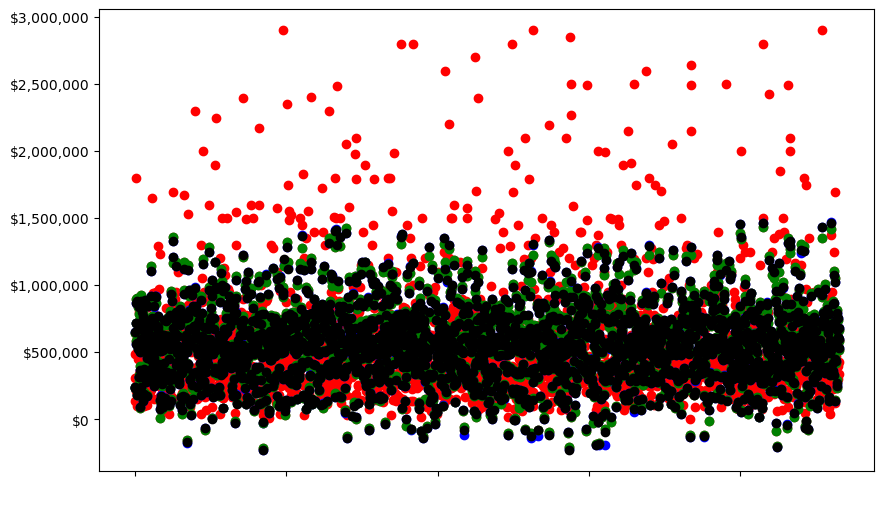

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(lasso_sfm_predict_df.index,lasso_sfm_predict_df["prediction"], color="brown")
plt.scatter(lasso_sfs_predict_df.index,lasso_sfs_predict_df["prediction"], color="blue")
plt.scatter(lasso_rfe_predict_df.index,lasso_rfe_predict_df["prediction"], color="green")
plt.scatter(lasso_bp_predict_df.index,lasso_bp_predict_df["prediction"], color="black")
plt.show()

In [25]:
lasso_bp_predict_df.sort_values(by='prediction', inplace=True)
lasso_bp_predict_df.reset_index(inplace=True)

lasso_sfm_predict_df.sort_values(by='prediction', inplace=True)
lasso_sfm_predict_df.reset_index(inplace=True)

lasso_sfs_predict_df.sort_values(by='prediction', inplace=True)
lasso_sfs_predict_df.reset_index(inplace=True)

lasso_rfe_predict_df.sort_values(by='prediction', inplace=True)
lasso_rfe_predict_df.reset_index(inplace=True)

y_test_df.sort_values(by='price', inplace=True)
y_test_df.reset_index(inplace=True)

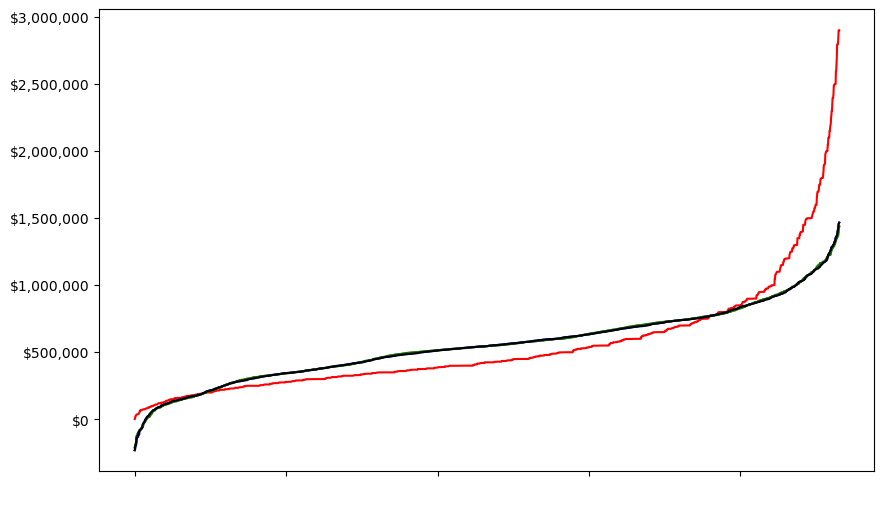

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.plot(y_test_df.index,y_test_df["price"], color="red")
plt.plot(lasso_sfm_predict_df.index,lasso_sfm_predict_df["prediction"], color="brown")
plt.plot(lasso_sfs_predict_df.index,lasso_sfs_predict_df["prediction"], color="blue")
plt.plot(lasso_rfe_predict_df.index,lasso_rfe_predict_df["prediction"], color="green")
plt.plot(lasso_bp_predict_df.index,lasso_bp_predict_df["prediction"], color="black")
plt.show()

In [27]:
results_dict

{'model': ['Lasso Best Params',
  'Select From Model',
  'Sequential Feature Selector',
  'Recursive Feature Elimination'],
 'explained variance score': ['0.413528582',
  '0.412534909',
  '0.411503194',
  '0.412534909'],
 'mae score': ['214,079.047688',
  '214,333.413424',
  '214,408.235731',
  '214,333.413424'],
 'mse score': ['103,916,325,992.270248',
  '104,103,878,550.355606',
  '104,278,409,374.292221',
  '104,103,878,550.355606'],
 'r2 score': ['0.413192', '0.412133', '0.411148', '0.412133'],
 'mean fit time': [0.5704637050628663,
  0.010481882095336913,
  0.014208030700683594,
  0.007661581039428711]}

In [28]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score,mean fit time
model,,,,,
Lasso Best Params,0.413528582,"214,079.047688","103,916,325,992.270248",0.413192,0.570464
Select From Model,0.412534909,"214,333.413424","104,103,878,550.355606",0.412133,0.010482
Sequential Feature Selector,0.411503194,"214,408.235731","104,278,409,374.292221",0.411148,0.014208
Recursive Feature Elimination,0.412534909,"214,333.413424","104,103,878,550.355606",0.412133,0.007662
